In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


## 1. 데이터 폴더 생성 (1회만 실행)

In [69]:
# female 엑셀파일에 id가 겹치는게 있음 -> male 엑셀파일도 있을 수 있음
# 남여 나눠서 압축 1개 풀고, 엑셀 1개 concat 하는 식으로 수행
# 이미지 이름은 1부터 rename 하였음

path= '골밀도 데이터/BoneAge/'
data_path_F = '골밀도 데이터/data_F/'
data_path_M = '골밀도 데이터/data_M/'

# xlsx파일과 zip파일 경로 추출
xls_path = glob.glob(path + "*.xlsx")
zip_path = glob.glob(path + "*.zip")

In [70]:
# 남여 zip 파일 분류
zip_path_F = [f_path for f_path in zip_path if f_path.split('/')[-1][3]=='F']
zip_path_M = [f_path for f_path in zip_path if f_path.split('/')[-1][3]=='M']

# 남여 xlsx 파일 분류
xlsx_path_F = [f_xls for f_xls in xls_path if f_xls.split('/')[-1][3]=='F']
xlsx_path_M = [m_xls for m_xls in xls_path if m_xls.split('/')[-1][3]=='M']

## 분류된 파일을 보면 연령대 순서가 동일함을 알 수 있음
# print(zip_path_M)
# print(xlsx_path_M)

# 이미지 이름을 1부터 rename
i = 1
df_f = pd.DataFrame() # female 엑셀파일 모아둘 데이터프레임 생성

# zip 함수로 female zip파일, 엑셀파일 세트로 하나씩 추출
for zip_file, xlsx_file in zip(zip_path_F, xlsx_path_F):
    zipfile.ZipFile(zip_file).extractall(data_path_F)
    xlsx_f = pd.read_excel(xlsx_file, index_col = 0)
    df_f = pd.concat([df_f, xlsx_f], axis = 0)
    
    for filename in os.listdir(data_path_F):
        # 01_F 식으로 된 파일명만 바꾸기
        if filename.split('.')[0][-1] == 'F':
            new_filename = str(i) + '.jpg'
            
            old_path = os.path.join(data_path_F, filename)
            new_path = os.path.join(data_path_F, new_filename)
            
            os.rename(old_path, new_path)
            i+= 1
        else:
            continue

df_f = df_f.reset_index(drop = True)

In [71]:
# 이중 폴더 꺼내는 것 제외하면 female 작업과 같음
for zip_file in zip_path_M:
    zipfile.ZipFile(zip_file).extractall(data_path_M)

df_m = pd.DataFrame()
folder_path = glob.glob(data_path_M + "BA*")
for in_path, xlsx_file in zip(folder_path, xlsx_path_M):
    xlsx_m = pd.read_excel(xlsx_file, index_col=0)
    df_m = pd.concat([df_m, xlsx_m], axis = 0)
    
    temp = os.listdir(in_path)
    for tmp in temp:
        os.rename(in_path + '/' + tmp, data_path_M + str(i) + '.jpg')
        i+= 1
    
    os.rmdir(in_path)
    
df_m = df_m.reset_index(drop = True)

In [72]:
# 두 데이터를 합치기 위한 data 폴더 생성
merged_folder = '골밀도 데이터/data/'
os.makedirs(merged_folder, exist_ok=True)

# data_F의 이미지를 data 폴더로 이동
for filename in os.listdir(data_path_F):
    source_path = os.path.join(data_path_F, filename)
    destination_path = os.path.join(merged_folder, filename)
    shutil.move(source_path, destination_path)
    
# data_M의 이미지를 data 폴더로 이동
for filename in os.listdir(data_path_M):
    source_path = os.path.join(data_path_M, filename)
    destination_path = os.path.join(merged_folder, filename)
    shutil.move(source_path, destination_path)

# 빈 폴더 제거
os.rmdir(data_path_F)
os.rmdir(data_path_M)

In [73]:
# 남여 데이터프레임 합치고 필요한 열만 가져옴
df = pd.concat([df_f, df_m], axis = 0).reset_index(drop = True)
df['No'] = df.index + 1
df['No'] = df['No'].apply(lambda x : str(x) + '.jpg')

df['boneage'] = (df['BA 1'] + df['BA 2']) / 2
df['성별'] = df['성별'].map({2 : 'F', 1:'M'})

In [74]:
df.to_csv('골밀도 데이터/total_data.csv', index = 0)

### __train, test 셋 분리__

In [75]:
df.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1698,8255049,2007-08-03,F,1,9.969863,129.5,26.9,16.1,2017-01-09,2017-07-20,9.75,9.75,NaN,1.jpg,9.750
1,1897,8537405,2008-08-22,F,1,9.989041,132.0,31.0,17.8,2018-02-28,2018-08-16,10.50,11.00,NaN,2.jpg,10.750
2,1422,7942635,2005-01-19,F,1,10.008219,136.4,33.2,17.9,2015-01-20,2015-01-20,11.00,11.25,NaN,3.jpg,11.125
3,1475,7995857,2005-02-09,F,1,10.049315,133.5,31.2,17.6,2015-02-25,2015-02-25,10.00,10.25,NaN,4.jpg,10.125
4,1888,8520261,2008-09-11,F,1,10.060274,130.6,23.7,13.9,2018-10-01,2018-10-01,10.00,9.75,NaN,5.jpg,9.875


In [76]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state = 42, stratify = df['성별'])
train_df.to_csv('골밀도 데이터/train_data.csv', index = 0)
test_df.to_csv('골밀도 데이터/test_data.csv', index = 0)

In [77]:
train_id = train_df.No.values.tolist()
test_id = test_df.No.values.tolist()

# train_image와 test_image 폴더 생성
data_folder = '골밀도 데이터/data/'
train_image_folder = '골밀도 데이터/train_image/'
test_image_folder = '골밀도 데이터/test_image/'

os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(test_image_folder, exist_ok=True)

In [78]:
# # train 데이터의 이미지 이동
for user_id in train_id:
    source_path = os.path.join(data_folder, f'{user_id}')
    destination_path = os.path.join(train_image_folder, f'{user_id}')
    
    # 이미지 이동
    shutil.move(source_path, destination_path)
    
# test 데이터의 이미지 이동
for user_id in test_id:
    source_path = os.path.join(data_folder, f'{user_id}')
    destination_path = os.path.join(test_image_folder, f'{user_id}')
    
    # 이미지 이동
    shutil.move(source_path, destination_path)

# os.rmdir('골밀도 데이터/data/') Thumb.db 라는 숨김파일이 있어 빈 폴더 지우는 코드로 지워지지 않음
shutil.rmtree('골밀도 데이터/data/', ignore_errors=True) # 폴더와 안의 내용을 강제로 지우는 코드

## 2. 이미지 전처리
(여기서부터 실행하면 됨)

In [6]:
train_df = pd.read_csv('골밀도 데이터/train_data.csv')
train_df = train_df[['No', '성별', 'boneage']]
train_df.columns = ['id', 'gender', 'boneage']
train_df['id'] = train_df['id'].astype('str')

mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()

train_df['boneage_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

train_df.head()

,id,gender,boneage,boneage_z
0,98.jpg,F,12.125,0.615059
1,1162.jpg,M,7.125,-0.634581
2,636.jpg,M,10.500,0.208926
3,990.jpg,M,4.125,-1.384365
4,618.jpg,M,9.625,-0.009761


In [9]:
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state= 42)
df_train

,id,gender,boneage,boneage_z
753,26.jpg,F,10.000,0.083962
215,290.jpg,F,3.500,-1.540570
294,466.jpg,F,8.375,-0.322171
49,725.jpg,M,12.250,0.646300
720,845.jpg,M,14.125,1.114915
...,...,...,...,...
106,528.jpg,F,9.125,-0.134725
270,728.jpg,M,13.500,0.958710
860,391.jpg,F,6.250,-0.853268
435,1032.jpg,M,5.250,-1.103196


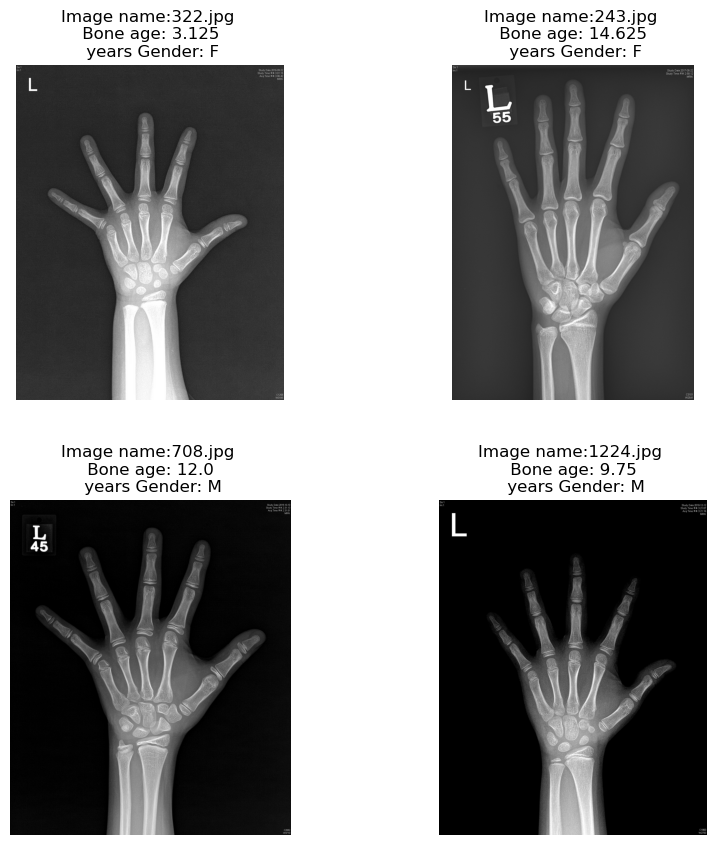

In [10]:
import matplotlib.image as mping
fig, axes = plt.subplots(2,2, figsize = (10, 10))
plt.subplots_adjust(hspace=0.3)
i = 0
for filename, boneage, gender in train_df[['id', 'boneage', 'gender']].sample(4).values:
    img = mping.imread('골밀도 데이터/train_image/' + str(filename))
    axes[i//2,i%2].imshow(img)
    axes[i//2,i%2].set_title('Image name:{} \n Bone age: {} \n years Gender: {}'.format(filename, boneage, gender))
    axes[i//2,i%2].axis('off')
    i += 1
    
plt.show()

**Setting up Image Data Generators!**<br>
We use image data generators for both training, testing and preprocessing of images. Validation set is already broken off from training set. 

In [11]:
#library required for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

2024-01-08 18:27:18.363481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 18:27:18.363575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 18:27:18.365292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 18:27:18.378109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 18:27:19.422611: W tensorflow/comp

In [12]:
#reducing down the size of the image 
img_size = 256

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [13]:
#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = './골밀도 데이터/train_image',
    x_col= 'id',
    y_col= 'boneage',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = './골밀도 데이터/train_image',
    x_col = 'id',
    y_col = 'boneage',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = './골밀도 데이터/test_image',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 791 validated image filenames.
Found 198 validated image filenames.
Found 248 images belonging to 1 classes.


In [22]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = './골밀도 데이터/train_image',
                            x_col = 'id',
                            y_col = 'boneage', 
                            target_size = (img_size, img_size),
                            batch_size = 198,
                            class_mode = 'other'
                            )) 

Found 198 validated image filenames.


In [23]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [24]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [25]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential
import tensorflow as tf

model_1 = tf.keras.applications.xception.Xception(input_shape = (img_size, img_size, 3),
                                           include_top = False,
                                           weights = 'imagenet')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dense(1, activation = 'linear'))


#compile model
model_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20881981 (79.66 MB)
Trainable params: 20827453 (79.45 MB)
Non-trainable params: 54528 (213.00 KB)
________

In [18]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_dir = '.\logs'
%tensorboard --logdir {logs_dir}

/tmp/ipykernel_3851706/4293522416.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_2.fit_generator(train_generator,


Epoch 1/50
25/25 [==============================] - 30s 1s/step - loss: 1.8869 - mae_in_months: 4.5197 - val_loss: 19.1775 - val_mae_in_months: 16.0073 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 28s 1s/step - loss: 2.3116 - mae_in_months: 4.7937 - val_loss: 26.8463 - val_mae_in_months: 19.6349 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 28s 1s/step - loss: 2.3204 - mae_in_months: 4.9825 - val_loss: 25.8281 - val_mae_in_months: 18.8749 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 29s 1s/step - loss: 1.6251 - mae_in_months: 4.1871 - val_loss: 11.4007 - val_mae_in_months: 12.3887 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 29s 1s/step - loss: 0.9386 - mae_in_months: 3.1339 - val_loss: 6.2650 - val_mae_in_months: 8.9055 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 28s 1s/step - loss: 0.5580 - mae_in_months: 2.3653 - val_loss: 5.1152 - val_mae_in_months: 8.5259 - lr: 0.0010
Epoch 7/50
25/

Reusing TensorBoard on port 6007 (pid 3858628), started 0:19:10 ago. (Use '!kill 3858628' to kill it.)

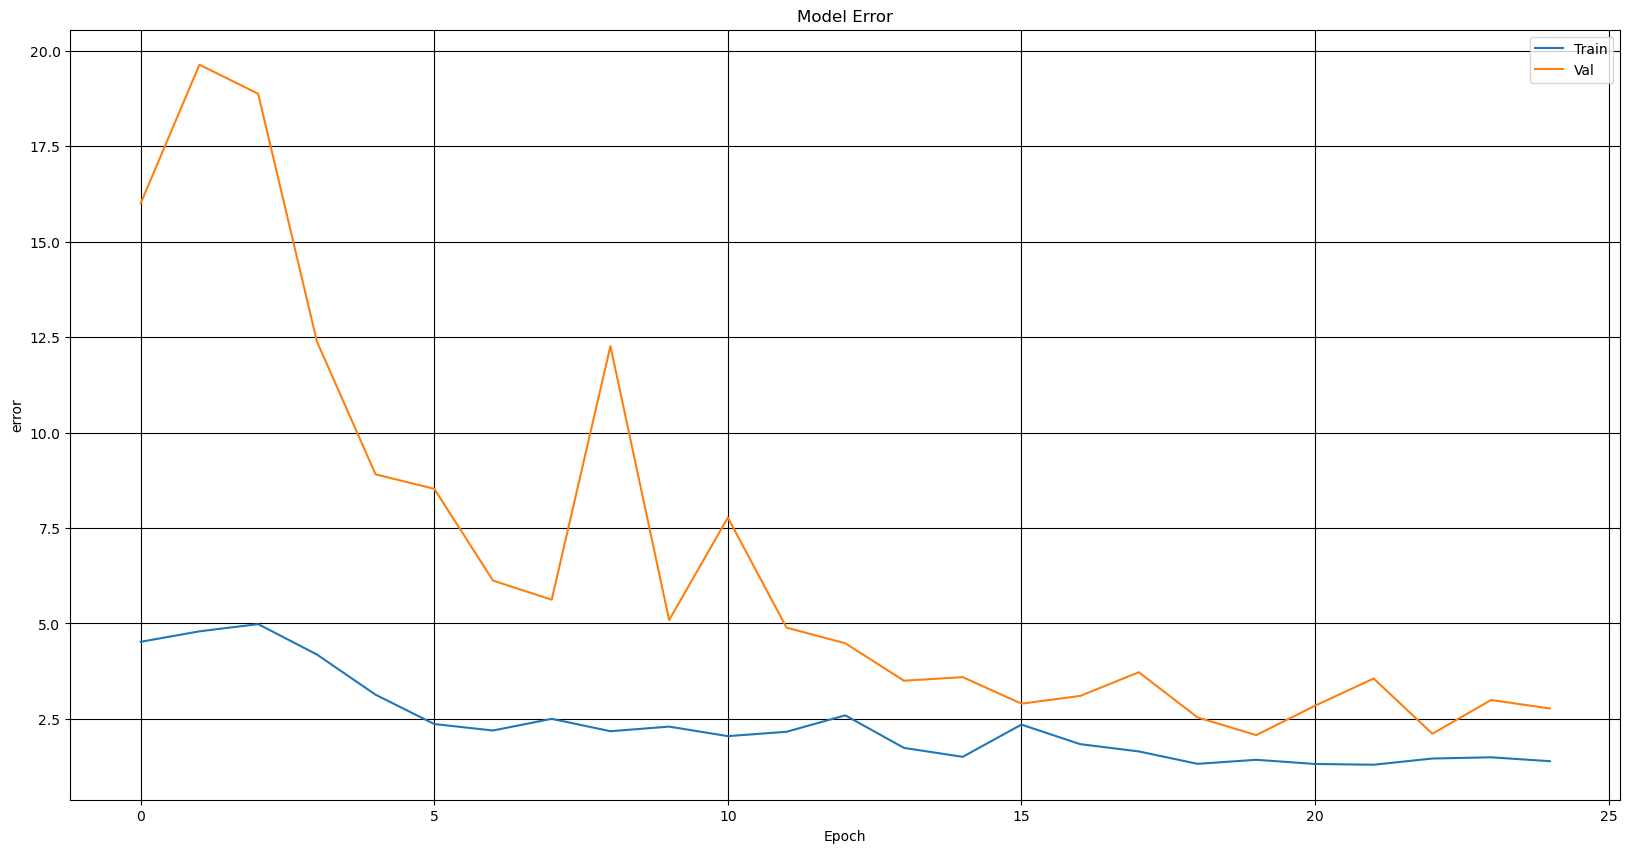

In [28]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')

#model checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

#tensorboard callback
logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]


#fit model
history = model_2.fit_generator(train_generator,
                            steps_per_epoch = 25,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 50,
                            callbacks= callbacks)
history
%tensorboard --logdir logs
plot_it(history)


In [ ]:
model_2.load_weights('best_model.h5')
pred = mean_bone_age + std_bone_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
# fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

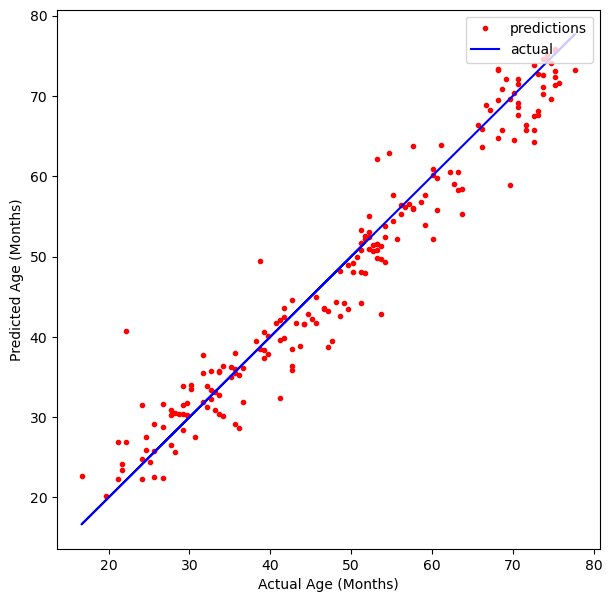

In [30]:
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [31]:
test_generator.reset()
y_pred = model_2.predict_generator(test_generator)
predicted = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predicted)
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions": predicted_months})
# results.to_csv("results.csv",index=False)
results

/tmp/ipykernel_3851706/1413812802.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model_2.predict_generator(test_generator)


,Filename,Predictions
0,test_image/100.jpg,70.126053
1,test_image/1013.jpg,34.480347
2,test_image/1017.jpg,56.620644
3,test_image/1022.jpg,37.025780
4,test_image/1023.jpg,32.253838
...,...,...
243,test_image/974.jpg,54.538383
244,test_image/980.jpg,34.273521
245,test_image/981.jpg,24.458717
246,test_image/987.jpg,70.833588


In [49]:
results['id'] = results['Filename'].apply(lambda x : int(x.split('/')[-1].split('.')[0]))
results.sort_values(by = 'id')

,Filename,Predictions,id
60,test_image/2.jpg,53.723717,2
224,test_image/9.jpg,32.983414,9
50,test_image/14.jpg,39.134808,14
51,test_image/15.jpg,24.718760,15
65,test_image/21.jpg,65.456573,21
...,...,...,...
39,test_image/1205.jpg,23.558477,1205
40,test_image/1206.jpg,66.513382,1206
42,test_image/1220.jpg,61.325035,1220
43,test_image/1231.jpg,24.945549,1231


In [44]:
result_test = pd.read_csv('./골밀도 데이터/test_data.csv')
result_test['boneage'] = (result_test['BA 1'] + result_test['BA 2']) / 2
result_test = result_test[['No', 'boneage']]
result_test['id'] = result_test['No'].apply(lambda x : int(x.split('.')[0]))
result_test.sort_values(by = 'id')

,No,boneage,id
35,2.jpg,10.750,2
112,9.jpg,11.375,9
55,14.jpg,11.250,14
11,15.jpg,11.125,15
7,21.jpg,10.750,21
...,...,...,...
114,1205.jpg,9.000,1205
51,1206.jpg,8.000,1206
59,1220.jpg,9.250,1220
4,1231.jpg,10.375,1231


In [ ]:
sorted(results.Filename.apply(lambda x:int(x.split('/')[-1].split('.')[0])).values)